In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import time
import random as random
from mpl_toolkits.mplot3d import Axes3D


# Funciones

In [2]:
import numpy as np

def multiplicar_vectores(v1, v2):
    # Convierte las listas en vectores de NumPy
    vector1 = np.array(v1)
    vector2 = np.array(v2)

    # Calcula la matriz resultante
    matriz_resultante = np.outer(vector1, vector2)

    return matriz_resultante

# Ejemplo de uso
vector_a = [1, 2, 3]
vector_b = [4, 5, 6]

matriz_resultante = multiplicar_vectores(vector_a, vector_b)

print("Vector A:", vector_a)
print("Vector B:", vector_b)
print("Matriz resultante:")
print(matriz_resultante)


Vector A: [1, 2, 3]
Vector B: [4, 5, 6]
Matriz resultante:
[[ 4  5  6]
 [ 8 10 12]
 [12 15 18]]


In [3]:
sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)

kronecker(sy, 0, 1)

NameError: name 'kronecker' is not defined

In [3]:
# Funcion que me hace el producto de kronecker de las matrices identidad y ponemos en la posicion pos una matriz dada
def kronecker(matriz, pos, n):
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
  #res = np.zeros((int(2**n), int(2**n)))
  if(pos == 0):
    res = matriz
  else:
    res = id

  for i in range(1, n):
    if(i == pos):
      res = np.kron(res, matriz)
    else:
      res = np.kron(res, id)
  return res

# Funcion que me crea el hamiltoninano del modelo de Dicke dado un cierto numero de spines y su operador salto
def dicke(N, params):
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)

  sigma = params[0]
  w = params[1]
  k = params[2]
  g = params[3]

  suma1 = kronecker(0.5*sz, 0, N)
  suma2 = kronecker(0.25*np.dot(sx, sx), 0, N)
  suma3 = kronecker(0.5*sx, 0, N)

  i = 1
  while(i < N):
    #print(i)
    suma1 += kronecker(0.5*sz, i, N)
    suma2 += kronecker(0.25*np.dot(sx, sx), i, N)
    suma3 += kronecker(0.5*sx, i, N)
    i += 1

  H = sigma*suma1 - ((4.0*w*g*g)/(4.0*w**2 + k**2))*(1.0/N)*suma2
  J = ((2.0*np.abs(g)*np.sqrt(k))/(np.sqrt(N*(4*w*w + k*k))))*suma3

  return H, J

# Funcion que me hace el ketbra de dos vectores
def ketbra(v1, v2):
  m = np.outer(v1, np.conjugate(v2))
  return m

# Funcion que me genera una matriz densidad inicial a partir de una combinacion lineal de los autoestados de Sz
def densidad(N):
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)

  # Construimos el operador sz
  suma = kronecker(0.5*sz, 0, N)
  i = 1
  while(i < N):
    suma += kronecker(0.5*sz, i, N)
    i += 1
  spin = sp.Matrix(suma, dtype = complex)
  #print(spin)

  # Creamos la base de autoestados de sz
  todo = spin.eigenvects()
  base = [np.asarray(tup[2], dtype = complex) for tup in todo]
  #base = [np.linalg.eig(spin)[1][:, i] for i in range(spin.shape[0])]
  #print(base)

  # Construimos el vector inicial
  a, b = random.random(), random.random()
  ini = (a + b*1.j)*base[0]
  for i in range(1, len(base)):
    a, b = random.random(), random.random()
    ini += (a + b*1.j)*base[i]
  # Le hacemos el ketbra para construir la matriz densidad

  ini = ini/(np.linalg.norm(ini))
  print('El inicial es: ' + str(ini) + ' y su shape es: ' + str(ini.shape))
  ini = np.reshape(ini, (1, max(ini.shape)))
  d = ketbra(ini.T, ini.T)
  res = d/(np.linalg.norm(d))
  return res, ini


# Funcion que me crea una matriz cuadrada de simbolos
def matriz_cuadrada(n):
   matriz = sp.Matrix(n, n, lambda i,j: sp.Symbol('d_(%d)(%d)' % (i,j)))
   return matriz

# Iniciamos la semilla
import random
seed = 3457493
random.seed(a = seed, version = 2)

# Funcion que calcula el hamiltoniano efectivo
def H_eff(H, saltos):
  suma = np.zeros((H.shape[0], H.shape[1]), dtype = complex)
  for salto in saltos:
    suma += np.matrix(np.dot(salto.H, salto), dtype = complex)
  Heff = H - 0.5*(1.j)*suma
  return Heff

#Funcion para pasar de matriz a vector espacio de Fock-Liouville
def FL_vector(m):
  m_nuevo = np.reshape(m, m.shape[0]*m.shape[1])
  return sp.Matrix(m_nuevo, dtype = complex)

# Funcion para definir el Limbladiano como matriz en el espacio de Fock-Liouville
def Limblad(H, saltos):
  # Sacamos el hamiltoniano efectivo
  Heff = sp.Matrix(H_eff(H, saltos))

  # Creamos la matriz de simbolos
  d = matriz_cuadrada(H.shape[0])

  # Sacamos la suma de saltos
  suma = sp.zeros(H.shape[0], H.shape[1])
  for salto in saltos:
    suma += np.dot(np.dot(salto, d), salto.H)

  # Con esto, definimos el Limbladiano
  M = suma - sp.I*(np.dot(Heff, d) - np.dot(d, Heff.H))
  # Lo pasamos a vector
  M = FL_vector(M)

  # Lo pasamos de sistema de ecuaciones lineal a ecuacion matricial, b tiene que dar el vector de ceros
  #L, b = sp.linear_eq_to_matrix([elemento for elemento in M], [termino for termino in d])
  L, b = sp.linear_eq_to_matrix([M[i] for i in range(len(M))], [d[i] for i in range(len(d))])
  return L, b

# Funcion que calcula las nuevas probabilidades de salto y de no salto
def Calcularp(d, V):
  return np.trace(np.dot(np.dot(V, d), V.H))

# Funcion que nos calcula el nuevo estado tras un salto de tiempo
def NuevoEstado(d, V, H):
  return (np.dot(np.dot(V, d), (V.H)))/(np.sqrt(np.trace(np.dot(np.dot(V, d), (V.H)))))

# Funcion que nos hace un plot de lo que queramos
def ploteo_MC(d, tiempo):
  plt.ylabel(r'$\rho_{00}$')
  plt.xlabel('t')

  plt.plot(tiempo, d[0], 'bo', label = 'Random')
  plt.plot(tiempo, d[1], 'ro', label = 'Via del cero')
  plt.plot(tiempo, d[2], 'go', label = 'Via del no cero')
  plt.legend(loc = 'upper right')
  plt.show()
  return

# Funcion que nos saca la posicion del segundo valor mas grande en una lista
def segunda_posicion_mas_grande(lista):
    if len(lista) < 2:
        return "La lista no tiene suficientes elementos"

    # Encontrar el elemento más grande y su índice
    maximo = max(lista)
    indice_maximo = lista.index(maximo)

    # Eliminar el elemento más grande de la lista
    lista.remove(maximo)

    # Encontrar el segundo elemento más grande y su índice
    segundo_maximo = max(lista)
    indice_segundo_maximo = lista.index(segundo_maximo)

    # Ajustar el índice para tener en cuenta la eliminación del máximo anterior
    if indice_segundo_maximo >= indice_maximo:
        indice_segundo_maximo += 1

    return indice_segundo_maximo

# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
def Mpemba1(L, L_e, autovals, d, N, ini):

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(autovals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))

  todo = ((sp.Matrix(L1, dtype = complex)).H).eigenvects()
  vals = [tup[0] for tup in todo]
  vects = np.asarray([tup[2] for tup in todo], dtype = complex)
  #vals, vects = np.linalg.eig(L1)
  vals = list(np.array(vals, dtype = complex))
  print('Autovalores de L1: ')
  print(vals)

  # Normalizamos los autovectores de la matriz L1
  #vects = [matriz/np.linalg.norm(matriz) for matriz in vects]

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-14
  es_cero = [(np.abs(np.real(vals[i])) < tol) for i in range(len(vals))]
  #print(es_cero)

  if(any(es_cero)):
    print('Se puede hacer la vía del cero, con el autovalor: ')
    # Nos vamos al caso en el que un autovalor es 0
    indice = es_cero.index(True)
    print(vals[indice])
    print("Autovector con shape: " + str(vects[indice][0].shape) + ' es: ' + str(vects[indice][0]))
    U = ketbra(ini, vects[indice][0])
  else:
    print('No se ha podido hacer la via del cero')
    # Si no hay ningun autovalor que sea 0, se coje una pareja de autovalores con signo contrario
    U = np.zeros(d.shape)
  return U

# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
def Mpemba2(L, d, N, ini):
  # Diagonalizamos el lindbladiano
  # Sacamos los autovalores y los autovectores del Limbladiano
  L_H = np.matrix(L.H, dtype = complex)
  vals, L_e = np.linalg.eig(L_H)

  # Normalizamos las automatrices
  L_e = [np.reshape(matriz, (d.shape[0], d.shape[1])) for matriz in L_e]
  L_e = [matriz.T/(np.linalg.norm(matriz)) for matriz in L_e]

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(vals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))

  vals, vects = np.linalg.eig(L1)
  vals = list(vals)
  print('Autovalores de L1: ')
  print(vals)
  # Normalizamos los autovectores de la matriz L1
  vects = [matriz/np.linalg.norm(matriz) for matriz in vects]

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-14 # N = 5
  #tol = 1.0e-3
  es_cero = [(np.abs(np.real(vals[i])) < tol) for i in range(len(vals))]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  indice_contrario = 0
  indice_inicial = es_cero.index(False)
  es_contrario = [np.real(vals[indice_inicial])*np.real(vals[i]) < 0 for i in range(len(vals))]
  if(any(es_contrario)):
    indice_contrario = es_contrario.index(True)
    F = ketbra(vects[indice_inicial].T, vects[indice_contrario].T) + ketbra(vects[indice_contrario].T, vects[indice_inicial].T)
    s = np.arctan(np.sqrt((np.abs(vals[indice_inicial]))/(np.abs(vals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    print((vals[indice_inicial], vals[indice_contrario]))
    identidad = kronecker(id, 0, N)
    U = identidad + (np.cos(s) - 1.0)*(np.dot(F, F)) - 1.j*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)

  return U

def indices_mayores_que_100(matriz, n):
    indices = []
    filas = matriz.shape[0]
    columnas = matriz.shape[1]

    for i in range(filas):
        for j in range(columnas):
            if(np.real(matriz[i, j]) > n):
                indices.append((i, j))

    return indices

In [4]:
# Iniciamos la semilla
import random
seed = 3457493
random.seed(a = seed, version = 2)

# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
def Mpemba1(L, L_e, autovals, d, N, ini):

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(autovals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))

  todo = ((sp.Matrix(L1, dtype = complex)).H).eigenvects()
  vals = [tup[0] for tup in todo]
  vects = np.asarray([tup[2] for tup in todo], dtype = complex)
  vals = list(np.array(vals, dtype = complex))
  print('Autovalores de L1: ')
  print(vals)

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-14
  es_cero = [(np.abs(np.real(vals[i])) < tol) for i in range(len(vals))]

  if(any(es_cero)):
    print('Se puede hacer la vía del cero, con el autovalor: ')
    # Nos vamos al caso en el que un autovalor es 0
    indice = es_cero.index(True)
    print(vals[indice])
    print("Autovector con shape: " + str(vects[indice][0].shape) + ' es: ' + str(vects[indice][0]))
    U = ketbra(ini, vects[indice][0])
  else:
    print('No se ha podido hacer la via del cero')
    # Si no hay ningun autovalor que sea 0, se coje una pareja de autovalores con signo contrario
    U = np.zeros(d.shape)
  return U

def indices_mayores_que_100(matriz, n):
    indices = []
    filas = matriz.shape[0]
    columnas = matriz.shape[1]

    for i in range(filas):
        for j in range(columnas):
            if(np.real(matriz[i, j]) > n):
                indices.append((i, j))

    return indices

def indices_mayores_que_100(matriz, n):
    indices = []
    filas = matriz.shape[0]
    columnas = matriz.shape[1]

    for i in range(filas):
        for j in range(columnas):
            if(np.real(matriz[i, j]) > n):
                indices.append((i, j))

    return indices

In [5]:
# Funcion que nos saca el estado estacionario
def estacionario(L, d):
  # Sacamos los autovalores y los autovectores del Limbladiano
  todo = L.eigenvects()
  vals = [tup[0] for tup in todo]
  vects = [np.array(tup[2], dtype = complex) for tup in todo]

  # Sacamos el estado estacionario que es el autovector correspondiente al autovalor mas cercano a 0
  vals = np.array(vals, dtype = complex)
  espositivo = False
  for elemento in vals:
    if(elemento > 0.0):
      indice = list(vals).index(elemento)
      espositivo = True
  if(espositivo == False):
    reales = [np.real(valor) for valor in np.array(vals, dtype = complex)]
    minimo = max(reales)
    indice = reales.index(minimo)

  # Pasamos el estado estacionario a matriz
  r = np.reshape(vects[indice], (d.shape[0], d.shape[1]))

  if(np.imag(np.trace(r)) < 1e-10):
    res = r/np.trace(np.real(r))
  else:
    res = r/np.trace(r)
  return res

  # Funcion que nos resuelve la ecuacion maestra igualada a 0
def ec_maestra(L, H):
  d = FL_vector(matriz_cuadrada(H.shape[0]))
  sol = sp.solve(L*d, [d[i] for i in range(len(d))])
  return sol

# Funcion que resuelve el sistema mediante el metodo de montecarlo
def ResolverSistema(d0, H, salto, N, nveces):
  # Establecemos un limite de tiempo
  t = 0.0
  limite = 500.0
  tiempo = [t]
  dt = 0.01

  vector_fotones = []
  nfotones = 0 # numero de fotones
  res = [d0]
  # Hamiltoniano efectivo
  Heff = H_eff(H, salto)

  # Operadores de evolución y de salto del sistema
  V = [np.sqrt(dt)*J for J in salto]
  V_0 = kronecker(id, 0, N) - 1.j*dt*Heff

  intentos = [] #Aqui guardamos todos los resultados para cada realizacion

  # Calculamos las probabilides iniciales
  p0 = Calcularp(d0, V_0)
  p = Calcularp(d0, V[0])
  d = d0
  # Empezamos con el bucle
  while(t < limite):
    prob = random.random()
    if(prob < p):
      nfotones += 1
      d = NuevoEstado(d, V[0], H)
    else:
      d = NuevoEstado(d, V_0, H)
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    res.append(d)
    t += dt
    tiempo.append(t)

  vector_fotones.append(nfotones)
  intentos.append(res)
  # Ahora, hacemos el bucle otras nveces-1 veces para luego promediar
  indice = 1
  while(indice < nveces):
    d = d0
    nfotones = 0
    res = [d0]
    t = 0.0
    # Calculamos las probabilidades iniciales
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    while(t < limite):
      prob = random.random()
      if(prob < p):
        nfotones += 1
        d = NuevoEstado(d, V[0], H)
      else:
        d = NuevoEstado(d, V_0, H)
      p0 = Calcularp(d, V_0)
      p = Calcularp(d, V[0])
      res.append(d)
      t += dt
    intentos.append(res)
    indice += 1
    vector_fotones.append(nfotones)

  # Por último calculamos el promedio de las trayectorias
  suma = [0 for i in range(len(intentos[0]))]
  for i in range(len(intentos[0])):
    for elemento in intentos:
      suma[i] += elemento[i]
  final = [elemento/nveces for elemento in suma]
  return final, tiempo, vector_fotones

# Funcion que nos dice si la matriz l2 es hermitica segun los parametros que le pasemos
def L2hermitica(N, params, d):
  # Sacamos el hamiltoniano y los operadores de salto
  H, J = qubits(N, params)
  # Sacamos el lindbladiano
  L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])

  # Diagonalizamos el lindbladiano
  todo = (L.H).eigenvects()
  vals = np.array([tup[0] for tup in todo], dtype = complex)
  L_e = [tup[2] for tup in todo]

  # Normalizamos las automatrices
  L_e = [np.reshape(matriz, (d.shape[0], d.shape[1])) for matriz in L_e]

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(np.real(vals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = sp.Matrix(L1, dtype = complex)
  # Una vez obtenida L2, vemos si es hermitica
  eshermitica = False
  if(L1 == L1.H):
    eshermitica = True
  return eshermitica, vals[indice_segundo_maximo]

def eliminar_duplicados(lista):
    # Convierte la lista a un conjunto para eliminar duplicados
    conjunto_sin_duplicados = set(lista)

    # Convierte el conjunto de nuevo a una lista
    lista_sin_duplicados = list(conjunto_sin_duplicados)

    return lista_sin_duplicados

# Ejemplo de uso
mi_lista = [1, 2, 3, 2, 4, 5, 1, 6, 7, 8, 6, 9]
lista_sin_duplicados = eliminar_duplicados(mi_lista)

# Funcion que nos obtiene la transformacion unitaria del efecto Mpemba a partir del lindbladiano
def Mpemba2(L, L_e, vals, d, N, ini):

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  lista_vals =  list(-np.real(np.array(vals, dtype = complex)))
  maximo = max(lista_vals)
  print('Maximo: ' + str(maximo))
  indice_maximo = lista_vals.index(max(lista_vals))
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1

  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = sp.Matrix(L1, dtype = complex)

  todo = L1.eigenvects()
  autovals = [tup[0] for tup in todo]
  autovects = [np.array(tup[2][0], dtype = complex) for tup in todo]
  autovals = list(np.array(autovals, dtype = complex))
  print('Autovalores de L1: ')
  print(autovals)

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-10 # N = 5
  autovals = eliminar_duplicados(autovals)
  es_cero = [(np.abs(np.real(autovals[i])) < tol) for i in range(len(autovals))]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  indice_contrario = 0
  indice_inicial = es_cero.index(False)
  autovals = eliminar_duplicados(autovals)
  es_contrario = [np.real(autovals[indice_inicial])*np.real(autovals[i]) < 0 for i in range(len(autovals))]
  if(any(es_contrario)):
    indice_contrario = es_contrario.index(True)
    print('(indice contrario, indice inicial, len(autovects)) = ' + str(indice_contrario) + ', ' + str(indice_inicial) + ', '  + ' ' + str(autovects[0].shape))
    F = ketbra(autovects[indice_inicial], autovects[indice_contrario]) + ketbra(autovects[indice_contrario], autovects[indice_inicial])
    s = np.arctan(np.sqrt((np.abs(autovals[indice_inicial]))/(np.abs(autovals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    print((autovals[indice_inicial], autovals[indice_contrario]))
    identidad = kronecker(id, 0, N)
    U = identidad + (np.cos(s) - 1.0)*(np.dot(F, F)) - 1.j*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)
  return U

# Funcion que te calcula el estado estacionario del lindbladiano, le pasamos los autovalores y autovecores
def estacionario(vals, vects, d):
  vals = np.array(vals, dtype = complex)
  espositivo = False
  indices_positivos = []
  for elemento in vals:
    if(elemento > 0.0):
      indices_positivos.append(list(vals).index(elemento))
      #indice = list(vals).index(elemento)
      espositivo = True
  if(espositivo == True):
    valores_positivos = [vals[i] for i in indices_positivos]
    indice = list(-np.real(vals)).index(max(list(-np.real(valores_positivos))))
  if(espositivo == False):
    reales = [np.real(valor) for valor in np.array(vals, dtype = complex)]
    minimo = max(reales)
    indice = reales.index(minimo)

  # Pasamos el estado estacionario a matriz
  r = np.reshape(vects[indice], (d.shape[0], d.shape[1]))
  if(np.imag(np.trace(r)) < 1e-10):
    res = r/np.trace(np.real(r))
  else:
    res = r/np.trace(r)
  return res

def estacionario_bueno(vals, vects, d):
  vals_copia = list(vals)
  # Sacamos los autovalores que son 0
  estacionarios = [num for num in vals_copia if np.allclose(np.abs(num), 0.0)]
  # Sacamos los indices de esos autovalores en la lista vals
  indices_est = [vals_copia.index(num) for num in estacionarios]
  # Sacamos los autovectores correspondientes y le hacemos reshape
  m_est = [np.reshape(vects[indice], d.shape) for indice in indices_est]

  m_est = [elemento/np.trace(elemento) for elemento in m_est]
  return m_est

# Funcion que, dado un vector y su dimension, me genera una base de vectores ortonormales en la cual este mismo vector es el primero
def generar_base_ortonormal(vector, dim):
    # Normalizar el primer vector
    v1 = vector / np.linalg.norm(vector)
    v1 = np.squeeze(np.asarray(v1, dtype = complex))

    # Generar una matriz aleatoria de dimensión (dim x dim)
    random_matrix = np.matrix(np.random.randn(dim, dim), dtype = complex)

    # Realizar el proceso de Gram-Schmidt para generar los vectores ortogonales restantes
    base = [v1]
    for i in range(1, dim):
        # Obtener el siguiente vector aleatorio
        #v = np.reshape(random_matrix[i], (1, max(random_matrix[i].shape)))
        v = np.squeeze(np.asarray(random_matrix[i], dtype = complex))
        #v = np.asarray(random_matrix[i], dtype = complex)
        #v = np.reshape(v, (1, max(v.shape)))
        # Restar las proyecciones de los vectores anteriores
        for j in range(i):
            v -= np.dot(v, base[j].T) * base[j]

        # Normalizar el vector resultante
        v /= np.linalg.norm(v)

        # Agregar el vector a la base ortonormal
        base.append(v)

    return base

# Ejemplo de uso
dimension = 3
vector_dado = np.array([1, 2, 3])
base_ortonormal = generar_base_ortonormal(vector_dado, dimension)

print("Vector dado:", vector_dado)
print("Base ortonormal:")
for v in base_ortonormal:
    print(v)

Vector dado: [1 2 3]
Base ortonormal:
[0.26726124+0.j 0.53452248+0.j 0.80178373+0.j]
[-0.80106818+0.j -0.33922262+0.j  0.49317114+0.j]
[ 0.53559424+0.j -0.77408897+0.j  0.3375279 +0.j]


In [6]:
# Funcion que me crea el hamiltoniano del modelo de los qubits
def qubits(N, params):
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)

  sigma = params[0]
  k = params[1]

  suma1 = kronecker(0.5*sx, 0, N)
  suma2 = kronecker(0.5*(sx - 1.j*sy), 0, N)

  i = 1
  while(i < N):
    #print(i)
    suma1 += kronecker(0.5*sz, i, N)
    suma2 += kronecker(0.5*(sx - 1.j*sy), i, N)
    i += 1

  H = sigma*suma1
  J = np.sqrt(k)*suma2

  return H, J

def densidad_qubit(N):
  sx = np.matrix([[0.0, -1.0], [1.0, 0.0]], dtype = complex)
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)

  # Construimos el operador sz
  suma = kronecker(0.5*sx, 0, N)
  i = 1
  while(i < N):
    suma += kronecker(0.5*sx, i, N)
    i += 1
  spin = suma

  # Creamos la base de autoestados de sz
  base = [np.linalg.eig(spin)[1][:, i] for i in range(spin.shape[0])]

  # Construimos el vector inicial
  a, b = random.random(), random.random()
  ini = (a + b*1.j)*base[0]
  for i in range(1, len(base)):
    a, b = random.random(), random.random()
    ini += (a + b*1.j)*base[i]
  # Le hacemos el ketbra para construir la matriz densidad

  ini = ini/(np.linalg.norm(ini))
  d = ketbra(np.array(ini), np.array(ini))
  res = d/(np.linalg.norm(d))
  return res, ini

# Funcion que nos calcula la transformacion de Mpemba2, pero teniendo en cuenta la matriz de cambio de base
def Mpemba2_mejorada(L, L_e, vals, d, N, ini):

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  """
  lista_vals =  list(np.real(np.array(vals, dtype = complex)))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1
  """
  segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(vals)))
  #indice_segundo_maximo = vals.index(segundo_maximo)
  print('Indice segundo maximo: ' + str(indice_segundo_maximo))
  # La pasamos a matriz
  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = sp.Matrix(L1, dtype = complex)
  print('Autovalor asociado al l1: ' + str(vals[indice_segundo_maximo]))

  # Diagonalizamos la matriz L1
  todo = L1.eigenvects()
  autovals = [tup[0] for tup in todo]
  autovects = [np.array(tup[2][0], dtype = complex) for tup in todo]
  autovals = list(np.array(autovals, dtype = complex))
  print('Autovalores de L1: ')
  print(autovals)

  # Ahora, generamos la base auxiliar para el vector estado inicial
  base_aux = generar_base_ortonormal(ini, int(2**N))

  base_aux = np.array([elemento for elemento in base_aux], dtype = complex)
  # Con esto, podemos generar la primera transformacion
  U_cambio = ketbra(autovects[0], base_aux[0])
  for i in range(1, N):
    U_cambio += ketbra(autovects[i], base_aux[i])

  #autovals = eliminar_duplicados(autovals)
  tol = 1e-16
  es_cero = [(np.abs(autovals[i]) < tol) for i in range(len(autovals))]
  #es_cero = [np.allclose(np.abs(elemento), 0.0) for elemento in autovals]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  indice_contrario = 0
  indice_inicial = es_cero.index(False)
  print(indice_inicial)
  #autovals = eliminar_duplicados(autovals)
  es_contrario = [np.real(autovals[indice_inicial])*np.real(autovals[i]) < 0 for i in range(len(autovals))]
  if(any(es_contrario)):
    indice_contrario = es_contrario.index(True)
    #print('(indice contrario, indice inicial, len(autovects)) = ' + str(indice_contrario) + ', ' + str(indice_inicial) + ', '  + ' ' + str(autovects[0].shape))
    F = ketbra(autovects[indice_inicial], autovects[indice_contrario]) + ketbra(autovects[indice_contrario], autovects[indice_inicial])
    s = np.arctan(np.sqrt((np.abs(autovals[indice_inicial]))/(np.abs(autovals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    #print((autovals[indice_inicial], autovals[indice_contrario]))
    identidad = kronecker(id, 0, N)
    U = identidad + (np.cos(s) - 1.0)*(np.dot(F, F)) - 1.j*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)
  return np.dot(U, U_cambio), U_cambio
  #return U, U_cambio

# Funcion que genera la transformacion de Mpemba1, pero haciendo antes lo de la matriz de cambio de base
def Mpemba1_mejorada(L, L_e, autovals, d, N, ini):

  # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  """
  lista_vals =  list(np.real(autovals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1
  """
  segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(autovals)))

  # Hacemos reshape
  L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))

  # Diagonalizamos la matriz L1
  todo = (sp.Matrix(L1, dtype = complex)).eigenvects()
  vals = [tup[0] for tup in todo]
  vects = np.asarray([tup[2] for tup in todo], dtype = complex)
  vects = [np.reshape(elemento, (1, max(elemento.shape))) for elemento in vects]
  vals = list(np.array(vals, dtype = complex))
  #print('Autovalores de L1: ')
  #print(vals)

  # Ahora, generamos la base auxiliar para el vector ini
  base_aux = generar_base_ortonormal(ini, int(2**N))
  base_aux = np.asarray([elemento for elemento in base_aux], dtype = complex)
  U_cambio = ketbra((vects[0]), base_aux[0])
  for i in range(1, N):
    U_cambio += ketbra((vects[i]), base_aux[i])

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  tol = 1.0e-14
  es_cero = [(np.allclose(np.abs(vals[i]), 0.0)) for i in range(len(vals))]

  if(any(es_cero)):
    print('Se puede hacer la vía del cero, con el autovalor: ')
    # Nos vamos al caso en el que un autovalor es 0
    indice = es_cero.index(True)
    print(vals[indice])
    #U = ketbra(ini, vects[indice][0])
    U = ketbra(ini, vects[indice])
  else:
    print('No se ha podido hacer la via del cero')
    # Si no hay ningun autovalor que sea 0, se coje una pareja de autovalores con signo contrario
    U = np.zeros(d.shape)
  #return np.dot(U, U_cambio), U_cambio
  return U, U_cambio

# Funcion que nos hace la exponencial de una matriz de traza nula
def exponencial_matriz(matriz):
  n = matriz.shape
  id = np.eye(matriz.shape[0], matriz.shape[1])
  d = np.linalg.det(matriz)
  res = np.cos(np.sqrt(d))*id + (np.sin(np.sqrt(d))/np.sqrt(d))*matriz
  return res

# Funcion que nos construye la transformacion de Mpemba, pero a base de transformaciones a un solo qubit
def Mpemba_sep(theta, phi, N):
  #id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  #id = np.eye(matriz.shape[0], matriz.shape[1])
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)

  # Construimos el operador sz
  #spin_z = kronecker(0.5*sz, 0, N)
  #spin_y = kronecker(0.5*sy, 0, N)
  spin_z = kronecker(sz, 0, N)
  spin_y = kronecker(sy, 0, N)
  id = np.eye(spin_y.shape[0], spin_y.shape[1])
  U1 = np.cos(0.5*phi)*id + 1.j*np.sin(0.5*phi)*spin_z
  U2 = np.cos(0.5*theta)*id + 1.j*np.sin(0.5*theta)*spin_y
  #U1 = exponencial_matriz(0.5*1.j*phi*spin_z)
  #U2 = exponencial_matriz(0.5*1.j*theta*spin_y)
  res = np.dot(U1, U2)
  i = 1
  while(i < N):
    spin_z = kronecker(0.5*sz, i, N)
    spin_y = kronecker(0.5*sy, i, N)
    #U1 = exponencial_matriz(0.5*1.j*phi*spin_z)
    #U2 = exponencial_matriz(0.5*1.j*theta*spin_y)
    U1 = np.cos(0.5*phi)*id + 1.j*np.sin(0.5*phi)*spin_z
    U2 = np.cos(0.5*theta)*id + 1.j*np.sin(0.5*theta)*spin_y
    res = np.dot(res, np.dot(U1, U2))
    i += 1
  return res

# Funcion que da la evolución temporal de la diagonalizacion del lindbladiano
def solucion(d, r, l, autovals, tiempo):
  res = []
  suma = 0.0
  tol = 1e-16
  for t in tiempo:
    suma = 0.0
    #suma = r[0]*np.trace(np.dot(l[0], d))*np.exp(t*autovals[0])
    for i in range(0, len(r)):
      suma += r[i]*np.trace(np.dot(l[i], d))*np.exp(t*autovals[i])
    res.append(suma)
  return res

In [7]:
def segundo_max_distinto_de_cero(lista):
    # Eliminamos los ceros de la lista
    tol = 1e-10
    lista_sin_ceros = [num for num in lista if np.abs(num) > tol]

    # Si no hay elementos o solo hay un elemento distinto de cero, no hay segundo máximo
    if len(lista_sin_ceros) < 2:
        return None

    # Encontramos el máximo
    maximo = max(lista_sin_ceros)

    # Eliminamos el máximo de la lista y encontramos el máximo restante
    #lista_sin_maximo = [num for num in lista_sin_ceros if num != maximo]
    #segundo_maximo = max(lista_sin_maximo)
    segundo_maximo = max(lista_sin_ceros)

    return segundo_maximo, lista.index(segundo_maximo)

# Ejemplo de uso
lista = [1, 5, 2, 6, 0, 9, 3, 0, 8]
segundo_max = segundo_max_distinto_de_cero(lista)
print("El segundo máximo distinto de cero en la lista es:", segundo_max)


def buscar_segundo_maximo(lista):
    # Si la lista tiene menos de dos elementos, no hay segundo máximo
    if len(lista) < 2:
        return None

    # Inicializamos el máximo y el segundo máximo con los dos primeros elementos de la lista
    maximo = max(lista[0], lista[1])
    segundo_max = min(lista[0], lista[1])

    # Iteramos sobre los elementos restantes de la lista para encontrar el máximo y el segundo máximo
    for num in lista[2:]:
        if num > maximo:
            segundo_max = maximo
            maximo = num
        elif num > segundo_max and num != maximo:
            segundo_max = num

    return segundo_max, lista.index(segundo_max)

El segundo máximo distinto de cero en la lista es: (9, 5)


In [ ]:
# Hamiltoniano, operador salto y hamiltoniano efecivo
N = 2
sigma = 1.0
w = 1.0*sigma
k = 1.0*sigma
g = 1.0*sigma
params = [sigma, w, k, g]
H, J = dicke(N, params)

In [ ]:
sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
kronecker(0.5*sz, 0, N) + kronecker(0.5*sz, 1, N), H

In [ ]:
L.shape

(16, 16)

In [ ]:
L, b = Limblad(H, [J])
sp.simplify(L)

In [ ]:
d, ini = densidad(N)
sp.Matrix(d, dtype = complex)

El inicial es: [[[0.40131106+0.2239223j ]
  [0.12776737+0.25390612j]
  [0.05074864+0.6187196j ]
  [0.06724557+0.56400717j]]] y su shape es: (1, 4, 1)


Matrix([
[0.211191758330234 - 5.70837038843799e-18*I,   0.108129698304449 - 0.0732853722680036*I,    0.158911105558501 - 0.236935264557832*I,    0.153280169538822 - 0.211284530112789*I],
[  0.108129698304449 + 0.0732853722680036*I, 0.080792818710238 + 1.58281184678707e-18*I,   0.163580715653619 - 0.0661667825318159*I,   0.151796661884623 - 0.0549876486817208*I],
[   0.158911105558501 + 0.236935264557832*I,   0.163580715653619 + 0.0661667825318159*I, 0.385389371746441 - 2.98752918660349e-18*I,   0.352374911924799 + 0.0129835523658596*I],
[   0.153280169538822 + 0.211284530112789*I,   0.151796661884623 + 0.0549876486817209*I,   0.352374911924799 - 0.0129835523658596*I, 0.322626051213087 - 6.23939490044569e-20*I]])

In [ ]:
np.trace(d)

(1-7.175481677258872e-18j)

Ahora, tenemos que buscar una transformación que deje la traza menor que un umbral

# Modelo de qubits

In [ ]:
# Diagonalizamos el lindbladiano
dt = 0.01 #salto de tiempo

# Medimos el tiempo
t1 = time.time()

# Matrices de Pauli
id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
num = np.matrix([[1.0, 0.0], [0.0, 0.0]], dtype = complex)

# Hamiltoniano, operador salto y hamiltoniano efecivo
N = 1
nveces = 1e3
sigma = 1.0
k = 4.0*sigma
params = [sigma, k]
H, J = qubits(N, params)
Heff = H_eff(H, [J])
print(Heff.shape)

# Matriz densidad
d0, ini = densidad_qubit(N)
print('densidad hecha')
L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])

print(L.shape)
todo = L.eigenvects()
#vals = list(sp.simplify(L.eigenvals()).keys())
autovals = np.asarray([tup[0] for tup in todo], dtype = complex)
autovects = [np.array(tup[2], dtype = complex) for tup in todo]

# Sacamos l2
# Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
lista_vals =  list(-np.real(autovals))
maximo = max(lista_vals)
indice_maximo = lista_vals.index(maximo)
lista_vals.remove(maximo)
segundo_maximo = max(lista_vals)
indice_segundo_maximo = lista_vals.index(segundo_maximo)
if indice_segundo_maximo >= indice_maximo:

  indice_segundo_maximo += 1

L1 = np.reshape(autovects[indice_segundo_maximo], (d0.shape[0], d0.shape[1]))

(2, 2)
densidad hecha


<ipython-input-3-6ab63186044f>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m[i, k] = v1[i]*v2_conj[k]


(4, 4)


In [ ]:
epsilon = 1e-3

phi = np.pi/2.0
theta = np.pi/2.0
U = Mpemba_sep(theta, phi, N)
new_rho = np.dot(U, np.dot(d0, np.conjugate(U.T)))
res = np.trace(np.dot(L1, new_rho))
res

In [ ]:
epsilon = 1e-2
posibles = []
phi = 0.0
theta = 0.0
traza = []
while(theta < np.pi):
  phi = 0.0
  while(phi < 2.0*np.pi):
    U = Mpemba_sep(theta, phi, N)
    new_rho = np.dot(U, np.dot(d0, np.conjugate(U.T)))
    res = np.trace(np.dot(L1, new_rho))
    if(np.abs(res) < epsilon):
      posibles.append([theta, phi])
      traza.append(res)
    phi += 0.01
  theta += 0.01

In [ ]:
len(posibles)

2129

In [ ]:
traza

Probamos a aplicarle alguna de las transformaciones para ver cómo sale

In [ ]:
# Definimos los angulos
theta_posible = posibles[0][0]
phi_posible = posibles[0][1]

# Creamos la transformacion con estos angulos y lo aplicamos
U = Mpemba_sep(theta_posible, phi_posible, N)
d0_new = np.dot(np.dot(U, d0), np.conjugate(U.T))

# Resolvemos el sistema con ambos casos
nveces = 1e3
v1, tiempo, n1 = ResolverSistema(d0, H, [J], N, nveces)
v2, tiempo, n2 = ResolverSistema(d0_new, H, [J], N, nveces)

dens = [v1, v2]

In [ ]:
autovals[:]

array([-4.00000000e+00+0.j, -7.73205081e+00+0.j, -4.26794919e+00+0.j,
        7.24776517e-66+0.j])

In [ ]:
r = np.reshape(autovects[62], d0.shape)
r = r/np.trace(r)

In [ ]:
r = estacionario(autovals, autovects, d0)
np.trace(r), np.trace(np.dot(r, r))

((1+0j), (0.9938271604938271+0j))

In [ ]:
np.trace(r), np.trace(np.dot(r, r))

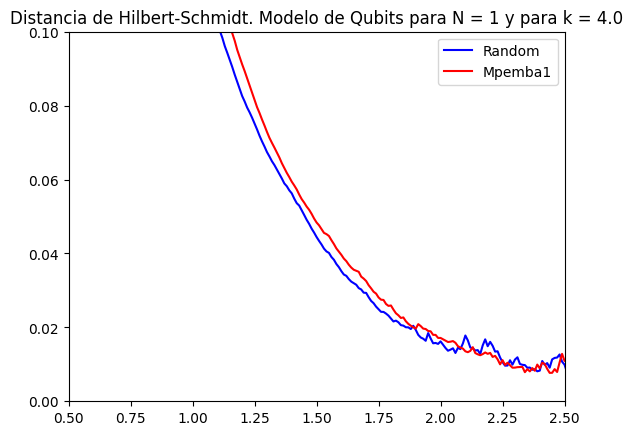

In [ ]:
#Sacamos la distancia de Hilbert Schmidt para todo tiempo t
#ob = [[np.sqrt(np.trace((v[i] - r))) for i in range(len(v))] for v in dens]
ob = [[np.sqrt(np.trace(np.dot((v[i] - r), (v[i] - r)))) for i in range(len(v))] for v in dens]
plt.plot(tiempo, ob[0], 'b-', label = 'Random')
plt.plot(tiempo, ob[1], 'r-', label = 'Mpemba1')
#plt.xlim(2, 200)
#plt.ylim(0.0, 0.5)
plt.ylim(0.0, 0.1)
plt.xlim(0.5, 2.5)
plt.legend(loc = 'upper right')
plt.title('Distancia de Hilbert-Schmidt. Modelo de Qubits para N = ' + str(N) + ' y para k = ' + str(k))
plt.show()
#ploteo_MC(ob, tiempo)

In [ ]:
def parametrizacion_esfera(r, theta_range, phi_range):
    theta_values = np.linspace(*theta_range, num=100)
    phi_values = np.linspace(*phi_range, num=100)

    theta, phi = np.meshgrid(theta_values, phi_values)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def esfera_partes(r, theta_values, phi_values):
  theta, phi = np.meshgrid(theta_values, phi_values)
  x = r * np.sin(theta) * np.cos(phi)
  y = r * np.sin(theta) * np.sin(phi)
  z = r * np.cos(theta)

  return x, y, z

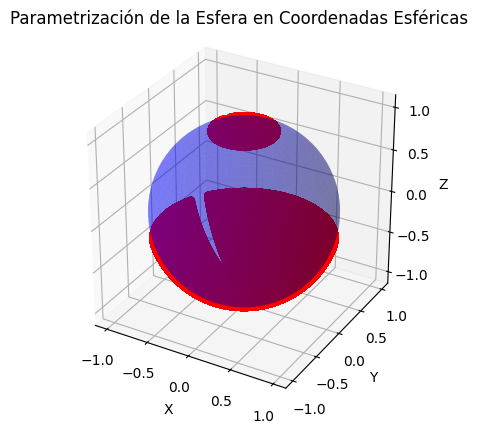

In [ ]:
from matplotlib import cm
# Parámetros de la esfera
radio = 1.0
theta_rango1 = (0, np.pi)  # Rango de ángulo polar de 0 a pi
phi_rango1 = (0, 2 * np.pi)  # Rango de ángulo azimutal de 0 a 2*pi

theta_values = [tup[0] for tup in posibles]
phi_values = [tup[1] for tup in posibles]
#theta_rango2 = (0, 0.5*np.pi)
#phi_rango2 = (0, 2*np.pi)

# Obtener las coordenadas para la parametrización
x1, y1, z1 = parametrizacion_esfera(radio, theta_rango1, phi_rango1)
x2, y2, z2 = esfera_partes(radio, theta_values, phi_values)

# Graficar la esfera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, y1, z1, color='b', alpha= 0.3)
#ax.plot_surface(x2, y2, z2, cmap = 'viridis', color = 'b', alpha = 0.9) # Alpha es la opacidad
#ax.plot_surface(x2, y2, z2, color = 'r', alpha = 1.0) # Alpha es la opacidad
ax.scatter(x2, y2, z2, c='r', marker='o', label='Puntos en la esfera')
# Cambiar la orientación de la vista
#ax.view_init(elev=0, azim=180)  # Elevación y azimut en grados
# Configuración adicional para mejorar la visualización
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Parametrización de la Esfera en Coordenadas Esféricas')

plt.show()

Vamos a ver para qué valores de k se tienen más posibles transformaciones

In [ ]:
N = 1
epsilon = 1e-2
sigma = 1.0
k = 0.2*sigma
numero_posibles = []
valores = []
while(k < 10.0):
  # Construimos el Lindbladiano
  params = [sigma, k]
  H, J = qubits(N, params)
  Heff = H_eff(H, [J])
  d0, ini = densidad_qubit(N)
  L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])

  # Diagonalizamos el lindbladiano
  todo = L.eigenvects()
  autovals = np.asarray([tup[0] for tup in todo], dtype = complex)
  autovects = [np.array(tup[2], dtype = complex) for tup in todo]

  # Sacamos l2
  lista_vals =  list(np.real(autovals))
  maximo = max(lista_vals)
  indice_maximo = lista_vals.index(maximo)
  lista_vals.remove(maximo)
  segundo_maximo = max(lista_vals)
  indice_segundo_maximo = lista_vals.index(segundo_maximo)
  if indice_segundo_maximo >= indice_maximo:
    indice_segundo_maximo += 1
  L1 = np.reshape(autovects[indice_segundo_maximo], (d0.shape[0], d0.shape[1]))

  # Sacamos los posibles angulos
  posibles = []
  traza = []
  phi = 0.0
  theta = 0.0
  while(theta < np.pi):
    phi = 0.0
    while(phi < 2.0*np.pi):
      U = Mpemba_sep(theta, phi, N)
      new_rho = np.dot(U, np.dot(d0, np.conjugate(U.T)))
      res = np.trace((np.dot(L1, new_rho)))
      if(res < epsilon):
        posibles.append([theta, phi])
        traza.append(res)
      phi += 0.01
    theta += 0.01
  numero_posibles.append([len(traza)])
  valores.append([k])
  #print(k)
  k += 0.2*sigma

<ipython-input-3-6ab63186044f>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m[i, k] = v1[i]*v2_conj[k]


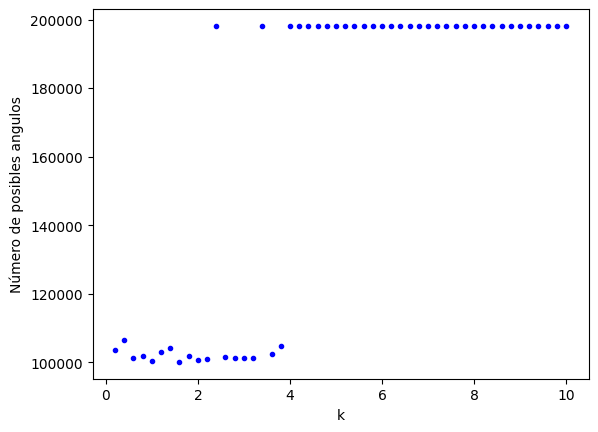

In [ ]:
plt.xlabel('k')
plt.ylabel('Número de posibles angulos')
plt.plot(valores, numero_posibles, 'b.')

# Modelo de Dicke

In [ ]:
res = np.dot(np.conjugate(d0.T), d0)
sp.Matrix(res, dtype = complex)

Matrix([
[                       0.116203611576102,  0.159856732889625 + 0.144518572834069*I, 0.165080512422499 + 0.0770880077627541*I,  0.131904886364978 + 0.075282824861775*I],
[ 0.159856732889625 - 0.144518572834069*I,                        0.399641562893484, 0.322966556160109 - 0.0992582144018703*I, 0.275083107666486 - 0.0604821090056966*I],
[0.165080512422499 - 0.0770880077627541*I, 0.322966556160109 + 0.0992582144018703*I,                         0.28565494714221, 0.237327642794024 + 0.0194438225292744*I],
[ 0.131904886364978 - 0.075282824861775*I, 0.275083107666486 + 0.0604821090056966*I, 0.237327642794024 - 0.0194438225292744*I,                        0.198499878388204]])

In [8]:
dt = 0.01 #salto de tiempo

# Medimos el tiempo
t1 = time.time()

# Matrices de Pauli
id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
num = np.matrix([[1.0, 0.0], [0.0, 0.0]], dtype = complex)

# Hamiltoniano, operador salto y hamiltoniano efecivo
N = 1
sigma = 1.0
nveces = 1e2
w = 1.0*sigma
k = 4.0*sigma
g = 4.0*sigma
params = [sigma, w, k, g]
H, J = dicke(N, params)

# Matriz densidad
d0, ini = densidad(N)

print('densidad hecha')
L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])

print(L.shape)
todo = L.eigenvects()
#vals = list(sp.simplify(L.eigenvals()).keys())
autovals = np.asarray([tup[0] for tup in todo], dtype = complex)
autovects = [np.array(tup[2], dtype = complex) for tup in todo]

# Sacamos l2
# Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
"""
lista_vals =  list(np.real(autovals))
maximo = max(lista_vals)
indice_maximo = lista_vals.index(maximo)
lista_vals.remove(maximo)
segundo_maximo = max(lista_vals)
indice_segundo_maximo = lista_vals.index(segundo_maximo)
if indice_segundo_maximo >= indice_maximo:
  indice_segundo_maximo += 1
"""
segundo_maximo, indice_segundo_maximo = segundo_max_distinto_de_cero(list(np.real(autovals)))
#indice_segundo_maximo = autovects.index(segundo_maximo)

L1 = np.reshape(autovects[indice_segundo_maximo], (d0.shape[0], d0.shape[1]))

El inicial es: [[[0.74267904+0.41439775j]
  [0.23645036+0.46988677j]]] y su shape es: (1, 2, 1)
densidad hecha
(4, 4)


In [9]:
dt = 0.01 #salto de tiempo

# Medimos el tiempo
t1 = time.time()

# Matrices de Pauli
id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
num = np.matrix([[1.0, 0.0], [0.0, 0.0]], dtype = complex)

# Hamiltoniano, operador salto y hamiltoniano efecivo
N = 1
sigma = 1.0
w = 1.0*sigma
k = 4.5*sigma
g = 4.0*sigma
params = [sigma, w, k, g]
H, J = dicke(N, params)

# Matriz densidad
d0, ini = densidad(N)

L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])
todo = L.eigenvects()
todoh = (L.H).eigenvects()
#vals = list(sp.simplify(L.eigenvals()).keys())
autovals = np.asarray([tup[0] for tup in todo], dtype = complex)
autovects_r = [np.asarray(tup[2], dtype = complex) for tup in todo]
autovects_r = [np.squeeze(np.asarray(elemento, dtype = complex)) for elemento in autovects_r]
autovects_r = [np.reshape(elemento, (1, len(elemento))) for elemento in autovects_r]

autovects_l = [np.asarray(tup[2], dtype = complex) for tup in todoh]
autovects_l = [np.squeeze(np.asarray(elemento, dtype = complex)) for elemento in autovects_l]
autovects_l = [np.reshape(elemento, (1, len(elemento))) for elemento in autovects_l]

# Sacamos l2
# Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
"""
lista_vals =  list(-np.real(autovals))
maximo = max(lista_vals)
indice_maximo = lista_vals.index(maximo)
lista_vals.remove(maximo)
segundo_maximo = max(lista_vals)
indice_segundo_maximo = lista_vals.index(segundo_maximo)
if indice_segundo_maximo >= indice_maximo:
  indice_segundo_maximo += 1
"""
segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(autovals)))
#indice_segundo_maximo = autovects.index(segundo_maximo)

#L1 = np.reshape(autovects[indice_segundo_maximo], (d0.shape[0], d0.shape[1]))

L1 = np.reshape(autovects_r[indice_segundo_maximo], (d0.shape[0], d0.shape[1]))

# Sacamos las transforaciones de Mpemba
ini = np.reshape(ini, (max(ini.shape)))
ini = np.squeeze(np.asarray(ini, dtype = complex))
"""
U2, U_cambio = Mpemba2_mejorada(L, autovects_r, np.array(autovals, dtype = complex), d0, N, ini) # Via no trivial (no cero)
U1, U_cambio = Mpemba1_mejorada(L, autovects_r, np.array(autovals, dtype = complex), d0, N, ini) # Via trivial (cero)
duracion = time.time() - t1

d0_exp1 = np.dot(np.dot(U1, d0), np.conjugate(U1.T))
d0_exp2 = np.dot(np.dot(U2, d0), np.conjugate(U2.T))
"""
print(d0.shape)

automatrix_r = [np.reshape(matriz, (d0.shape[0], d0.shape[1])) for matriz in autovects_r]
automatrix_l = [np.reshape(matriz, (d0.shape[0], d0.shape[1])) for matriz in autovects_l]

tfinal = 100
tiempo = np.linspace(0.0, tfinal, int(tfinal/dt))

#v1 = solucion(d0, automatrix_r, automatrix_l, autovals, tiempo)
#v2 = solucion(d0_exp1, automatrix_r, automatrix_l, autovals, tiempo)
#v3 = solucion(d0_exp2, automatrix_r, automatrix_l, autovals, tiempo)

#dens = [v1, v2, v3]
#dens = [v1, v2]

El inicial es: [[[0.06031191+0.73531346j]
  [0.07991758+0.67029081j]]] y su shape es: (1, 2, 1)
(2, 2)


In [ ]:
# Funcion que me genera una matriz densidad inicial a partir de una combinacion lineal de los autoestados de Sz
def densidad_p(N, inicial, final):
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)

  # Construimos el operador sz
  suma = kronecker(0.5*sz, 0, N)
  i = 1
  while(i < N):
    suma += kronecker(0.5*sz, i, N)
    i += 1
  spin = sp.Matrix(suma, dtype = complex)
  #print(spin)

  # Creamos la base de autoestados de sz
  todo = spin.eigenvects()
  base = [np.asarray(tup[2], dtype = complex) for tup in todo]
  #base = [np.linalg.eig(spin)[1][:, i] for i in range(spin.shape[0])]
  #print(base)

  # Construimos el vector inicial
  a, b = inicial + (final-inicial)*random.random(), inicial + (final-inicial)*random.random()
  ini = (a + b*1.j)*base[0]
  for i in range(1, len(base)):
    a, b = inicial + (final-inicial)*random.random(), inicial + (final-inicial)*random.random()
    ini += (a + b*1.j)*base[i]
  # Le hacemos el ketbra para construir la matriz densidad

  ini = ini/(np.linalg.norm(ini))
  ini = np.reshape(ini, (1, max(ini.shape)))
  d = ketbra(ini.T, ini.T)
  res = d/(np.linalg.norm(d))
  return res, ini


In [ ]:
p = -5.0
vectorp = []
res = []
veces = 10000
while(p < 5.0):
  print(p)
  traza = 0.0
  for i in range(veces):
    d, ini = densidad_p(N, 0.0 - p, 1.0+p)
    traza += np.trace(np.dot(L1, d))
  vectorp.append(p)
  res.append(traza/veces)
  p += 0.1
plt.title(r'Tr(l_2$\rho_0$)-p')
plt.xlabel('p')
plt.ylabel(r'Tr(l_2$\rho_0$)')
plt.plot(vectorp, res)

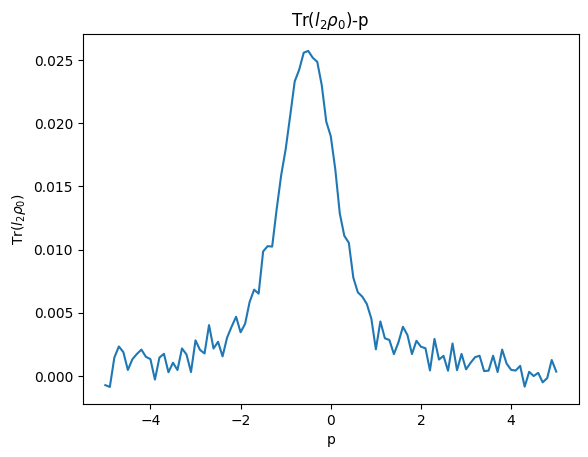

In [ ]:
plt.title(r'Tr($l_2$$\rho_0$)-p')
plt.xlabel('p')
plt.ylabel(r'Tr($l_2$$\rho_0$)')
plt.plot(vectorp, res)

In [ ]:
vectorp[res.index(max(res))]

NameError: name 'vectorp' is not defined

In [ ]:
autovals

array([-5.29411765e-02-9.98597633e-01j, -5.29411765e-02-9.98597633e-01j,
       -5.29411765e-02-9.98597633e-01j, -2.64705882e-01-9.87306987e-01j,
       -2.64705882e-01+9.87306987e-01j, -5.29411765e-02+9.98597633e-01j,
       -5.29411765e-02+9.98597633e-01j, -5.29411765e-02+9.98597633e-01j,
       -1.04994717e-01+1.99166892e+00j, -1.04994717e-01-1.99166892e+00j,
       -7.68017441e-67+1.96064319e-64j, -3.19422330e-01-1.03225123e-64j,
       -1.05882353e-01+1.37803549e-64j, -1.05882353e-01+9.80537535e-65j,
       -1.05882353e-01+8.70658731e-66j, -4.68844320e-65-4.33268723e-65j])

In [10]:
epsilon = np.abs(np.trace(np.dot(L1, d0)))
posibles = []
phi = 0.0
theta = 0.0
traza = []
while(theta < np.pi):
  phi = 0.0
  while(phi < 2.0*np.pi):
    U = Mpemba_sep(theta, phi, N)
    new_rho = np.dot(U, np.dot(d0, np.conjugate(U.T)))
    res = np.trace(np.dot(L1, new_rho))
    if(np.abs(res) < epsilon):
      posibles.append([theta, phi])
      traza.append(np.abs(res))
    phi += 0.01
  theta += 0.01

In [11]:
epsilon

0.7318126756414979

In [12]:
len(posibles)

194815

Probamos a aplicarle alguna de las transformaciones para ver cómo sale

In [ ]:
autovals

In [ ]:
sp.Matrix(np.reshape(autovects_l[14], d0.shape), dtype = complex)

Matrix([
[      -0.0417815155952759 - 0.18854970676722*I, -1.21225621060093e-63 + 4.37966682719641e-63*I, -2.88197115346045e-63 + 1.00539492537669e-62*I, -3.79233383885694e-64 - 3.31571035752379e-64*I],
[  -2.16175070715378e-63 + 3.583568444741e-63*I,         0.23710156155637 - 0.488568459632503*I,       -0.278883077151646 + 0.300018752865284*I, -1.36578953137627e-63 + 1.12546438136923e-62*I],
[ 1.13284380911426e-63 + 1.12839987599851e-62*I,       -0.278883077151646 + 0.300018752865284*I,         0.23710156155637 - 0.488568459632503*I, -3.10050550525477e-63 + 3.36680471482697e-63*I],
[-5.43997561472396e-64 - 2.88092316726894e-64*I, -8.61900962827757e-64 + 1.07274346728597e-62*I, -4.11157999878064e-64 + 4.62150497555853e-63*I,       -0.0417815155952759 - 0.18854970676722*I]])

In [13]:
# Definimos los angulos
#theta_posible = posibles[0][0]
#phi_posible = posibles[0][1]

indice = traza.index(min(traza))
print(min(traza))
theta_posible, phi_posible = posibles[indice]

# Creamos la transformacion con estos angulos y lo aplicamos
U = Mpemba_sep(theta_posible, phi_posible, N)
d0_new = np.dot(np.dot(U, d0), np.conjugate(U.T))
U2, U_cambio = Mpemba2_mejorada(L, autovects_l, np.array(autovals, dtype = complex), d0, N, ini) # Via no trivial (no cero)
U1, U_cambio = Mpemba1_mejorada(L, autovects_l, np.array(autovals, dtype = complex), d0, N, ini) # Via trivial (cero)

d0_exp1 = np.dot(np.dot(U1, d0), np.conjugate(U1.T))
d0_exp2 = np.dot(np.dot(U2, d0), np.conjugate(U2.T))
d0_exp2 = d0_exp2/np.trace(d0_exp2)
# Resolvemos el sistema con ambos casos
nveces = 6e1
"""v1, tiempo, n1 = ResolverSistema(d0, H, [J], N, nveces)
v2, tiempo, n2 = ResolverSistema(d0_new, H, [J], N, nveces)
"""
#automatrix_r = [elemento/np.trace(elemento) for elemento in automatrix_r]
#automatrix_l = [elemento/np.trace(elemento) for elemento in automatrix_l]

#automatrix_l[3], automatrix_r[3] = automatrix_l[3]/np.trace(automatrix_l[3]), automatrix_r[3]/np.trace(automatrix_r[3])
v1 = solucion(d0, automatrix_r, automatrix_l, autovals, tiempo)
v2 = solucion(d0_new, automatrix_r, automatrix_l, autovals, tiempo)
v3 = solucion(d0_exp1, automatrix_r, automatrix_l, autovals, tiempo)
v4 = solucion(d0_exp2, automatrix_r, automatrix_l, autovals, tiempo)
dens = [v1, v2, v3, v4]

1.8130484890657133e-06
Indice segundo maximo: 1
Autovalor asociado al l1: (-0.17347034768768757+5.8613795693595045e-65j)
Autovalores de L1: 
[(-0.7399330780380283+0.12835644831287762j), (0.7399330780380283-0.12835644831287762j)]
Vamos a probar la via del no cero
0
La s me sale: 0.7853981633974483 se ha cogido la s que sale de los autovalores: 
No se ha podido hacer la via del cero


In [ ]:
sp.Matrix(L1, dtype = complex).eigenvects()

In [ ]:
np.linalg.det(U2), np.trace(U2)

((7.548180997857943e-83-7.337983476516896e-83j),
 (0.03701586142090102+0.26896499011338937j))

In [ ]:
np.trace(d0_exp2)

(1-8.666684749742561e-34j)

In [ ]:
np.linalg.det(U1)

0.0

In [ ]:
sp.Matrix(automatrix_r[3], dtype = complex)

Matrix([
[-9.91485540448198e-63 + 2.63278952598479e-63*I,    -0.0391370006297473 + 0.0357851043574464*I,       0.583976078189984 + 0.0175921074443829*I, -2.3745051327199e-64 + 5.91674102953561e-64*I],
[       -0.26492097566182 + 0.123329035950155*I, 7.31823837731592e-63 - 1.32566032889804e-63*I,  -6.5322466388342e-63 + 5.89824888699643e-63*I,      0.255319981362521 + 0.0930239946582455*I],
[     -0.271401588108322 - 0.0135253257785596*I, 6.11413812369491e-63 - 5.84822171427604e-63*I, -6.87712617092077e-63 + 1.15586188519631e-63*I,      0.289519096197715 - 0.0396467828564162*I],
[-1.56447285689926e-64 - 6.34283214991158e-64*I,      -0.563154605765845 + 0.155545595074899*I,      0.0268320419957022 - 0.0457418849033032*I, 1.04924665468689e-62 - 2.73321492888691e-63*I]])

In [ ]:
np.trace(np.dot(np.conjugate(automatrix_r[3].T), automatrix_r[3])), np.linalg.norm(automatrix_r[3])

((1.0000000000000002+0j), 1.0)

In [ ]:
len(autovals)

4

In [ ]:
autovals[:]

array([-1.05556703e+01+3.10384481e-63j, -2.79744547e+00+3.76296173e-64j,
       -2.22021665e+00+3.36599107e-64j, -2.22021665e+00-7.76199236e-64j,
       -2.22021665e+00-1.22647053e-64j, -4.50406495e-01+4.36466774e-64j,
       -4.50406495e-01+6.81015345e-64j, -4.50406495e-01-3.52034815e-64j,
       -1.05601476e+01+1.20672710e-63j, -1.39648404e+00-1.04143599e+00j,
       -2.67062315e+00-1.02318604e-63j, -2.67062315e+00-8.19085004e-64j,
       -2.67062315e+00-2.71779009e-64j, -1.39648404e+00+1.04143599e+00j,
       -6.19320341e-64+1.92570159e-64j, -1.07997383e-63-2.77248814e-65j])

In [ ]:
r = np.reshape(autovects_r[15] + autovects_r[14], d0.shape)
r = r/np.trace(r)

In [15]:
r = estacionario_bueno(autovals, autovects_r, d0)
np.trace(r[0]), np.trace(np.dot(r[0], r[0]))

((1+0j), (0.5+0j))

In [16]:
len(r)

1

In [ ]:
sp.Matrix(r[0], dtype = complex)

Matrix([
[     0.0884848386667666 - 0.0243688383042627*I,  3.12982304238199e-63 - 1.54132260255965e-63*I, -5.53023586899086e-63 + 4.60889418459106e-63*I,  6.08859967233403e-64 - 2.33125396357493e-64*I],
[-4.14870244083235e-64 + 3.62835025220278e-64*I,       0.411515161333233 + 0.0243688383042627*I,      -0.323030322666467 - 0.0487376766085255*I, -2.28162343377686e-63 + 2.68340327817272e-63*I],
[-2.71327258206951e-63 + 2.13693794325932e-63*I,      -0.323030322666467 - 0.0487376766085255*I,       0.411515161333233 + 0.0243688383042627*I, -2.38745476673143e-64 + 4.46221630779721e-64*I],
[   6.484814593645e-64 + 6.48879723399745e-65*I, -6.32451297969071e-63 + 3.43328232419268e-63*I,   3.2596211953884e-63 - 8.59371967808575e-64*I,      0.0884848386667666 - 0.0243688383042627*I]])

In [ ]:
k = 1
np.trace(r[k]), np.trace(np.dot(r[k], r[k]))

((0.9999999999999999-6.938893903907228e-17j),
 (0.22617122031615775+0.003945788640037664j))

In [ ]:
matrices = [np.reshape(elemento, (d0.shape[0], d0.shape[1])) for elemento in autovects_r]

In [ ]:
trazas = [np.trace(elemento) for elemento in matrices]

In [ ]:
trazas

In [ ]:
len(r)

2

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


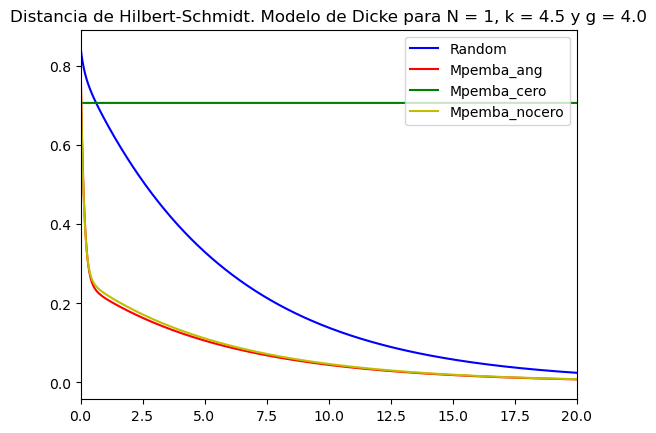

In [16]:
#Sacamos la distancia de Hilbert Schmidt para todo tiempo t
#ob = [[np.sqrt(np.trace((v[i] - r))) for i in range(len(v))] for v in dens]
m = 0
ob = [[np.sqrt(np.trace(np.dot(np.conjugate((v[i] - r[m]).T), (v[i] - r[m])))) for i in range(len(v))] for v in dens]
plt.plot(tiempo, ob[0], 'b-', label = 'Random')
plt.plot(tiempo, ob[1], 'r-', label = 'Mpemba_ang')
plt.plot(tiempo, ob[2], 'g-', label = 'Mpemba_cero')
plt.plot(tiempo, ob[3], 'y-', label = 'Mpemba_nocero')
plt.xlim(0, 20)
#plt.ylim(0.0, 0.5)
#plt.ylim(0.0, 1.0040)
#plt.xlim(0.0, 15.0)
plt.legend(loc = 'upper right')
plt.title('Distancia de Hilbert-Schmidt. Modelo de Dicke para N = ' + str(N) + ', k = ' + str(k) + ' y g = ' + str(g))
plt.show()
#ploteo_MC(ob, tiempo)

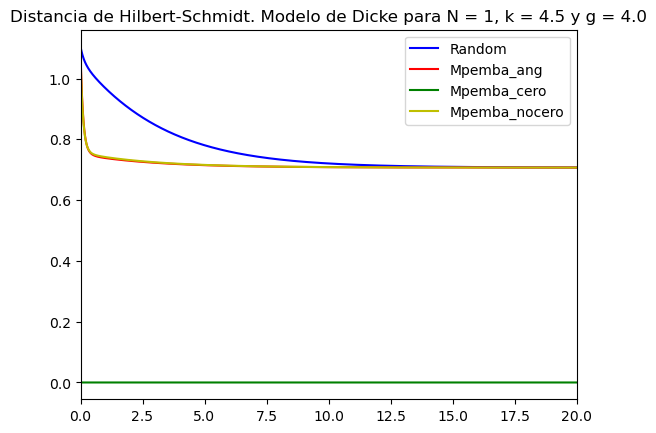

In [17]:
#Sacamos la distancia de Hilbert Schmidt para todo tiempo t
#ob = [[np.sqrt(np.trace((v[i] - r))) for i in range(len(v))] for v in dens]
ob = [[np.sqrt(np.trace(np.dot(np.conjugate((v[i]).T), (v[i])))) for i in range(len(v))] for v in dens]
plt.plot(tiempo, ob[0], 'b-', label = 'Random')
plt.plot(tiempo, ob[1], 'r-', label = 'Mpemba_ang')
plt.plot(tiempo, ob[2], 'g-', label = 'Mpemba_cero')
plt.plot(tiempo, ob[3], 'y-', label = 'Mpemba_nocero')
plt.xlim(0, 20)
#plt.ylim(0.0, 0.5)
#plt.ylim(0.0, 1.0040)
#plt.xlim(0.0, 15.0)
plt.legend(loc = 'upper right')
plt.title('Distancia de Hilbert-Schmidt. Modelo de Dicke para N = ' + str(N) + ', k = ' + str(k) + ' y g = ' + str(g))
plt.show()
#ploteo_MC(ob, tiempo)

In [18]:
def parametrizacion_esfera(r, theta_range, phi_range):
    theta_values = np.linspace(*theta_range, num=100)
    phi_values = np.linspace(*phi_range, num=100)

    theta, phi = np.meshgrid(theta_values, phi_values)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

def esfera_partes(r, theta_values, phi_values):
  theta, phi = np.meshgrid(theta_values, phi_values)
  x = r * np.sin(theta) * np.cos(phi)
  y = r * np.sin(theta) * np.sin(phi)
  z = r * np.cos(theta)

  return x, y, z

In [32]:
posibles_nuevo = []
res = []
for i in range(len(traza)):
    if(traza[i]/epsilon < 1e-5):
        res.append(traza[i])
        posibles_nuevo.append(posibles[i])
len(posibles_nuevo)

5

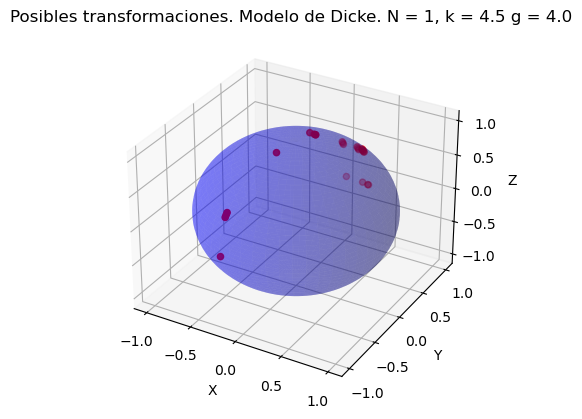

In [33]:
from matplotlib import cm
# Parámetros de la esfera
radio = 1.0
theta_rango1 = (0, np.pi)  # Rango de ángulo polar de 0 a pi
phi_rango1 = (0, 2 * np.pi)  # Rango de ángulo azimutal de 0 a 2*pi

theta_values = [tup[0] for tup in posibles_nuevo]
phi_values = [tup[1] for tup in posibles_nuevo]
#theta_rango2 = (0, 0.5*np.pi)
#phi_rango2 = (0, 2*np.pi)

# Obtener las coordenadas para la parametrización
x1, y1, z1 = parametrizacion_esfera(radio, theta_rango1, phi_rango1)
x2, y2, z2 = esfera_partes(radio, theta_values, phi_values)

# Graficar la esfera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, y1, z1, color='b', alpha= 0.3)
#ax.plot_surface(x2, y2, z2, cmap = 'viridis', color = 'b', alpha = 0.9) # Alpha es la opacidad
#ax.plot_surface(x2, y2, z2, color = 'r', alpha = 1.0) # Alpha es la opacidad
ax.scatter(x2, y2, z2, c='r', marker='o', label='Puntos en la esfera')
# Cambiar la orientación de la vista
#ax.view_init(elev=0, azim=180)  # Elevación y azimut en grados
# Configuración adicional para mejorar la visualización
#ax.set_aspect('equal')
ax.set_aspect('auto')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Posibles transformaciones. Modelo de Dicke. N = ' + str(N) + ', k = ' + str(k) + ' g = ' +  str(g))

plt.show()

Estudiamos el numero de posibles transformaciones según el valor de los parametros del modelo k, g

In [ ]:
N = 2
epsilon = 1e-2
sigma = 1.0
w = 1.0*sigma
k = 0.1*sigma
g = 0.1*sigma
numero_posibles = []
valores = []
while(k < 5.0):
  g = 0.1*sigma
  while(g < 5.0):
    # Construimos el Lindbladiano
    params = [sigma, w, k, g]
    H, J = dicke(N, params)
    Heff = H_eff(H, [J])
    d0, ini = densidad(N)
    L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(J, dtype = complex)])

    # Diagonalizamos el lindbladiano
    todo = L.eigenvects()
    autovals = np.asarray([tup[0] for tup in todo], dtype = complex)
    autovects = [np.array(tup[2], dtype = complex) for tup in todo]

    # Sacamos l2
    lista_vals =  list(-np.real(autovals))
    maximo = max(lista_vals)
    indice_maximo = lista_vals.index(maximo)
    lista_vals.remove(maximo)
    segundo_maximo = max(lista_vals)
    indice_segundo_maximo = lista_vals.index(segundo_maximo)
    if indice_segundo_maximo >= indice_maximo:
      indice_segundo_maximo += 1
    L1 = np.reshape(autovects[indice_segundo_maximo], (d0.shape[0], d0.shape[1]))

    # Sacamos los posibles angulos
    posibles = []
    traza = []
    phi = 0.0
    theta = 0.0
    while(theta < np.pi):
      phi = 0.0
      while(phi < 2.0*np.pi):
        U = Mpemba_sep(theta, phi, N)
        new_rho = np.dot(U, np.dot(d0, np.conjugate(U.T)))
        res = np.trace((np.dot(L1, new_rho)))
        if(res < epsilon):
          posibles.append([theta, phi])
          traza.append(res)
        phi += 0.01
      theta += 0.01
    numero_posibles.append([len(traza)])
    valores.append([k, g])
    #print(k)
    g += 1.0*sigma
  k += 1.0*sigma
  print(k)

<ipython-input-3-6ab63186044f>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m[i, k] = v1[i]*v2_conj[k]


1.1
2.1
3.1
4.1
5.1


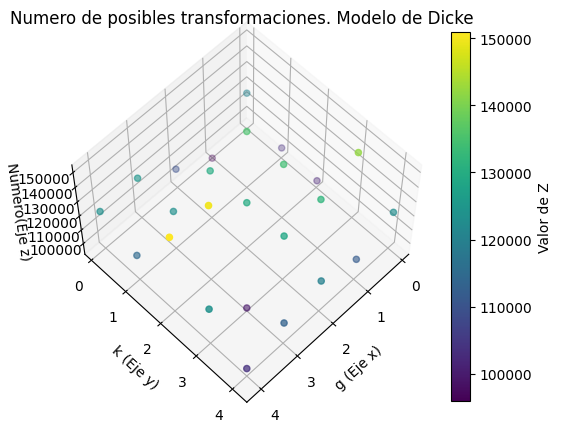

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Genera datos de ejemplo
# Supongamos que tienes una función z = f(x, y) = x^2 + y^2
def funcion_3d(x, y):
    return x**2 + y**2

# Genera valores para x, y
x = [elemento[0] for elemento in valores]
y = [elemento[1] for elemento in valores]

# Crea una malla de puntos (x, y)
#x, y = np.meshgrid(x, y)

# Calcula los valores de la función z para cada par (x, y)
z = numero_posibles

# Crea la figura y el objeto de los ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grafica el mapa de calor 3D
sc = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.view_init(elev=60.0, azim=45)
fig.colorbar(sc, label='Valor de Z')

# Añade etiquetas a los ejes
ax.set_xlabel('g (Eje x)')
ax.set_ylabel('k (Eje y)')
ax.set_zlabel('Numero(Eje z)')
ax.set_title('Numero de posibles transformaciones. Modelo de Dicke')

# Muestra la gráfica
plt.show()

# Modelo de Ising

In [ ]:

# Funcion que me da el hamiltoniano y los operadores de salto del modelo de Ising
def Ising(N, params):
  id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
  sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
  sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)

  sigma = params[0]
  v = params[1]
  alpha = params[2]
  k = params[3]

  suma1 = np.zeros((2**N, 2**N), dtype = complex)
  suma0 = np.zeros_like(suma1)
  saltos = []
  for i in range(N):
    saltos.append(0.5*np.sqrt(k)*(kronecker(sx, i, N) - 1.j*kronecker(sy, i, N)))
    suma1 += kronecker(sx, i, N)
    for j in range(N):
      if(i<j):
        suma0 += (np.dot(kronecker(sz, i, N), kronecker(sz, j, N)))/(i-j)**alpha

  H = sigma*suma1 + v*suma0
  return H, saltos
# Funcion que resuelve el sistema mediante el metodo de montecarlo
"""def ResolverIsing(d0, H, salto, N, nveces):
  # Establecemos un limite de tiempo
  t = 0.0
  limite = 100.0
  tiempo = [t]
  dt = 0.01

  vector_fotones = []
  nfotones = 0 # numero de fotones
  res = [d0]
  # Hamiltoniano efectivo
  Heff = H_eff(H, salto)

  # Operadores de evolución y de salto del sistema
  V = [np.sqrt(dt)*J for J in salto]
  V_0 = kronecker(id, 0, N) - 1.j*dt*Heff

  intentos = [] #Aqui guardamos todos los resultados para cada realizacion

  # Calculamos las probabilides iniciales
  p0 = Calcularp(d0, V_0)
  p = [Calcularp(d0, J) for J in salto]
  d = d0
  # Empezamos con el bucle
  while(t < limite):
    prob = random.random()
    if(prob < p):
      nfotones += 1
      d = NuevoEstado(d, V[0], H)
    else:
      d = NuevoEstado(d, V_0, H)
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    res.append(d)
    t += dt
    tiempo.append(t)

  vector_fotones.append(nfotones)
  intentos.append(res)
  # Ahora, hacemos el bucle otras nveces-1 veces para luego promediar
  indice = 1
  while(indice < nveces):
    d = d0
    nfotones = 0
    res = [d0]
    t = 0.0
    # Calculamos las probabilidades iniciales
    p0 = Calcularp(d, V_0)
    p = Calcularp(d, V[0])
    while(t < limite):
      prob = random.random()
      if(prob < p):
        nfotones += 1
        d = NuevoEstado(d, V[0], H)
      else:
        d = NuevoEstado(d, V_0, H)
      p0 = Calcularp(d, V_0)
      p = Calcularp(d, V[0])
      res.append(d)
      t += dt
    intentos.append(res)
    indice += 1
    vector_fotones.append(nfotones)

  # Por último calculamos el promedio de las trayectorias
  suma = [0 for i in range(len(intentos[0]))]
  for i in range(len(intentos[0])):
    for elemento in intentos:
      suma[i] += elemento[i]
  final = [elemento/nveces for elemento in suma]
  return final, tiempo, vector_fotones
# Funcion que me resuelve el sistema del modelo de Ising con el quantum montecarlo jump
def ResolverIsing()"""

'def ResolverIsing(d0, H, salto, N, nveces):\n  # Establecemos un limite de tiempo\n  t = 0.0\n  limite = 100.0\n  tiempo = [t]\n  dt = 0.01\n\n  vector_fotones = []\n  nfotones = 0 # numero de fotones\n  res = [d0]\n  # Hamiltoniano efectivo\n  Heff = H_eff(H, salto)\n\n  # Operadores de evolución y de salto del sistema\n  V = [np.sqrt(dt)*J for J in salto]\n  V_0 = kronecker(id, 0, N) - 1.j*dt*Heff\n\n  intentos = [] #Aqui guardamos todos los resultados para cada realizacion\n\n  # Calculamos las probabilides iniciales\n  p0 = Calcularp(d0, V_0)\n  p = [Calcularp(d0, J) for J in salto]\n  d = d0\n  # Empezamos con el bucle\n  while(t < limite):\n    prob = random.random()\n    if(prob < p):\n      nfotones += 1\n      d = NuevoEstado(d, V[0], H)\n    else:\n      d = NuevoEstado(d, V_0, H)\n    p0 = Calcularp(d, V_0)\n    p = Calcularp(d, V[0])\n    res.append(d)\n    t += dt\n    tiempo.append(t)\n\n  vector_fotones.append(nfotones)\n  intentos.append(res)\n  # Ahora, hacemos el buc

In [ ]:
N = 3
sigma = 1.0
v = 1.0*sigma
alpha = 1
k = 1.0*sigma
params = [sigma, v, alpha, k]
H, J = Ising(N, params)

H

array([[-2.5+0.j,  1. +0.j,  1. +0.j,  0. +0.j,  1. +0.j,  0. +0.j,
         0. +0.j,  0. +0.j],
       [ 1. +0.j,  0.5+0.j,  0. +0.j,  1. +0.j,  0. +0.j,  1. +0.j,
         0. +0.j,  0. +0.j],
       [ 1. +0.j,  0. +0.j,  1.5+0.j,  1. +0.j,  0. +0.j,  0. +0.j,
         1. +0.j,  0. +0.j],
       [ 0. +0.j,  1. +0.j,  1. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j,
         0. +0.j,  1. +0.j],
       [ 1. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  1. +0.j,
         1. +0.j,  0. +0.j],
       [ 0. +0.j,  1. +0.j,  0. +0.j,  0. +0.j,  1. +0.j,  1.5+0.j,
         0. +0.j,  1. +0.j],
       [ 0. +0.j,  0. +0.j,  1. +0.j,  0. +0.j,  1. +0.j,  0. +0.j,
         0.5+0.j,  1. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  1. +0.j,  0. +0.j,  1. +0.j,
         1. +0.j, -2.5+0.j]])

In [ ]:
id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
kronecker(sx, 1, N) + kronecker(sx, 0, N)

matrix([[0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j]])

In [ ]:
np.dot(kronecker(sz, 0, 2), kronecker(sz, 1, 2))

matrix([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [ ]:
J

[matrix([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]]),
 matrix([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])]

In [ ]:
dt = 0.01 #salto de tiempo

# Medimos el tiempo
t1 = time.time()

# Matrices de Pauli
id = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
sx = np.matrix([[0.0, 1.0], [1.0, 0.0]], dtype = complex)
sy = np.matrix([[0.0, -1.j], [1.j, 0.0]], dtype = complex)
sz = np.matrix([[1.0, 0.0], [0.0, -1.0]], dtype = complex)
num = np.matrix([[1.0, 0.0], [0.0, 0.0]], dtype = complex)

# Hamiltoniano, operador salto y hamiltoniano efecivo
N = 3
sigma = 1.0
v = 1.0*sigma
alpha = 1
k = 1.0*sigma
params = [sigma, v, alpha, k]
H, J = Ising(N, params)

# Matriz densidad
d0, ini = densidad(N)

L, b = Limblad(sp.Matrix(H, dtype = complex), [sp.Matrix(salto, dtype = complex) for salto in J])
todo = L.eigenvects()
todoh = (L.H).eigenvects()
#vals = list(sp.simplify(L.eigenvals()).keys())
autovals = np.asarray([tup[0] for tup in todo], dtype = complex)
autovects_r = [np.asarray(tup[2], dtype = complex) for tup in todo]
autovects_r = [np.squeeze(np.asarray(elemento, dtype = complex)) for elemento in autovects_r]
autovects_r = [np.reshape(elemento, (1, len(elemento))) for elemento in autovects_r]

autovects_l = [np.asarray(tup[2], dtype = complex) for tup in todoh]
autovects_l = [np.squeeze(np.asarray(elemento, dtype = complex)) for elemento in autovects_l]
autovects_l = [np.reshape(elemento, (1, len(elemento))) for elemento in autovects_l]

# Sacamos l2
# Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
lista_vals =  list(-np.real(autovals))
maximo = max(lista_vals)
indice_maximo = lista_vals.index(maximo)
lista_vals.remove(maximo)
segundo_maximo = max(lista_vals)
indice_segundo_maximo = lista_vals.index(segundo_maximo)
if indice_segundo_maximo >= indice_maximo:
  indice_segundo_maximo += 1

L1 = np.reshape(autovects_r[indice_segundo_maximo], (d0.shape[0], d0.shape[1]))

# Sacamos las transforaciones de Mpemba
ini = np.reshape(ini, (max(ini.shape)))
ini = np.squeeze(np.asarray(ini, dtype = complex))

print(d0.shape)

automatrix_r = [np.reshape(matriz, (d0.shape[0], d0.shape[1])) for matriz in autovects_r]
automatrix_l = [np.reshape(matriz, (d0.shape[0], d0.shape[1])) for matriz in autovects_l]

tfinal = 100
tiempo = np.linspace(0.0, tfinal, int(tfinal/dt))


El inicial es: [[[0.18087618+0.31068247j]
  [0.45696365+0.01757135j]
  [0.20461511+0.25069481j]
  [0.09874494+0.12185446j]
  [0.18823395+0.2669278j ]
  [0.20895237+0.4306044j ]
  [0.06833257+0.36031677j]
  [0.18288952+0.16914956j]]] y su shape es: (1, 8, 1)


<ipython-input-62-6ab63186044f>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m[i, k] = v1[i]*v2_conj[k]


(8, 8)


In [ ]:
autovals_l = np.asarray([tup[0] for tup in todoh], dtype = complex)
autovals == autovals_l
for i in range(len(autovals)):
  if(autovals[i]!=autovals_l[i]):
    print(i)
autovals[14], autovals_l[14]

5
12
13
14


((-1.1288479248624803e-63+6.793561042355815e-64j),
 (1.8662863553281566e-65+6.777818675530479e-65j))

In [ ]:
epsilon = np.abs(np.trace(np.dot(L1, d0)))
posibles = []
phi = 0.0
theta = 0.0
traza = []
while(theta < np.pi):
  phi = 0.0
  while(phi < 2.0*np.pi):
    U = Mpemba_sep(theta, phi, N)
    new_rho = np.dot(U, np.dot(d0, np.conjugate(U.T)))
    res = np.trace(np.dot(L1, new_rho))
    if(np.abs(res) < epsilon):
      posibles.append([theta, phi])
      traza.append(np.abs(res))
    phi += 0.01
  theta += 0.01

In [ ]:
len(posibles)

189456

In [ ]:
# Definimos los angulos
theta_posible = posibles[0][0]
phi_posible = posibles[0][1]

indice = traza.index(min(traza))
print(min(traza))
theta_posible, phi_posible = posibles[indice]

# Creamos la transformacion con estos angulos y lo aplicamos
U = Mpemba_sep(theta_posible, phi_posible, N)
d0_new = np.dot(np.dot(U, d0), np.conjugate(U.T))
U2, U_cambio = Mpemba2_mejorada(L, autovects_r, np.array(autovals, dtype = complex), d0, N, ini) # Via no trivial (no cero)
U1, U_cambio = Mpemba1_mejorada(L, autovects_r, np.array(autovals, dtype = complex), d0, N, ini) # Via trivial (cero)

d0_exp1 = np.dot(np.dot(U1, d0), np.conjugate(U1.T))
d0_exp2 = np.dot(np.dot(U2, d0), np.conjugate(U2.T))

# Resolvemos el sistema con ambos casos
nveces = 6e1
"""v1, tiempo, n1 = ResolverSistema(d0, H, [J], N, nveces)
v2, tiempo, n2 = ResolverSistema(d0_new, H, [J], N, nveces)
"""
v1 = solucion(d0, automatrix_r, automatrix_l, autovals, tiempo) # METERLE LA MATRIZ DE CAMBIO DE BASE
v2 = solucion(d0_new, automatrix_r, automatrix_l, autovals, tiempo)
v3 = solucion(d0_exp1, automatrix_r, automatrix_l, autovals, tiempo)
v4 = solucion(d0_exp2, automatrix_r, automatrix_l, autovals, tiempo)
dens = [v1, v2, v3, v4]

7.68533942187688e-06
Maximo: 2.407679331574387
Autovalores de L1: 
[(0.012700004316982483+0.010357252865137669j), (-0.012955287983286275-0.003761238486243849j), (0.050893130938347485+0.008633706384430758j), (0.012358224467163587+0.012025174368897567j), (0.009209709470242775-0.016186580364343776j), (-0.01314814688651336-0.004110860559359195j), (-0.0005645725016361549-0.0013016702785393747j), (-0.05849306182130052-0.005655783929979801j)]
Vamos a probar la via del no cero
(indice contrario, indice inicial, len(autovects)) = 2, 0,  (8, 1)
La s me sale: 0.27934991678422605 se ha cogido la s que sale de los autovalores: 
((-0.0005645725016361549-0.0013016702785393747j), (0.012358224467163587+0.012025174368897567j))


<ipython-input-62-6ab63186044f>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m[i, k] = v1[i]*v2_conj[k]


Autovalores de L1: 
[(0.012700004316982483-0.010357252865137669j), (-0.012955287983286275+0.003761238486243849j), (0.050893130938347485-0.008633706384430758j), (0.012358224467163587-0.012025174368897567j), (0.009209709470242775+0.016186580364343776j), (-0.0005645725016361549+0.0013016702785393747j), (-0.01314814688651336+0.004110860559359195j), (-0.05849306182130052+0.005655783929979801j)]
No se ha podido hacer la via del cero


In [ ]:
autovals[:]

array([-5.00000000e-01-4.68677891e-125j, -7.50000000e-01-1.98431348e+000j,
       -2.88583475e-64+3.16445417e-064j, -7.50000000e-01+1.98431348e+000j])

In [ ]:
r = np.reshape(autovects_r[15], d0.shape)
r = r/np.trace(r)

In [ ]:
r = estacionario(autovals, autovects_r, d0)
np.trace(r), np.trace(np.dot(r, r))

((1-4.2269473675139494e-17j), (0.5352841004186638-4.896592447369544e-17j))

In [ ]:
sp.Matrix(r, dtype = complex)

Matrix([
[                        0.164948453608247,                      -0.0824742268041237*I,                      -0.0824742268041237*I,  -0.0412371134020618 + 0.164948453608247*I],
[                     0.0824742268041237*I, 0.206185567010309 - 7.51497497771421e-18*I,                         0.0412371134020619,  -0.0824742268041237 - 0.103092783505155*I],
[                     0.0824742268041237*I,                         0.0412371134020619, 0.206185567010309 - 7.51497497771421e-18*I,  -0.0824742268041237 - 0.103092783505155*I],
[-0.0412371134020619 - 0.164948453608247*I,  -0.0824742268041237 + 0.103092783505155*I,  -0.0824742268041237 + 0.103092783505155*I, 0.422680412371134 - 1.50299499554284e-17*I]])

In [ ]:
np.trace(r), np.trace(np.dot(r, r))

((1-3.005989991085683e-17j), (0.44903815495801885-2.6020852139652106e-17j))

In [ ]:
matrices = [np.reshape(elemento, (d0.shape[0], d0.shape[1])) for elemento in autovects_r]

In [ ]:
np.dot(automatrix_r[5], automatrix_r[10])

array([[ 8.27160478e-65+2.06211799e-64j,  7.15623641e-64-2.09974501e-65j,
        -4.73595909e-64+7.40696930e-65j,  3.50678423e-64-3.77640574e-64j],
       [ 2.59313165e-04+1.23938925e-01j, -1.84985146e-63+3.92369953e-64j,
        -5.08898351e-01+3.04020464e-02j,  1.80394905e-63-1.71776917e-63j],
       [-4.54480108e-64+1.96863301e-64j, -1.86129995e-64+7.09165155e-64j,
        -8.71376414e-64-2.28761240e-65j,  1.85408546e-64-9.33267105e-64j],
       [-5.23633683e-01+2.56583115e-02j,  2.18637154e-63+9.43436325e-64j,
         1.63518657e-02-1.26730545e-01j,  2.30416949e-63+3.74784637e-64j]])

In [ ]:
trazas = [np.trace(elemento) for elemento in matrices]

In [ ]:
trazas

[(-1.7431796456864246e-64-7.145455977769915e-65j),
 (-7.804427464241994e-65-1.823199723006756e-64j),
 (2.6347212566803956e-66+8.082644072095876e-65j),
 (4.114551798800593e-65+9.139825586039353e-65j),
 (1.2561389505850472e-64-1.604906332771682e-64j),
 (-7.158969090475943e-64+2.3900833905665136e-64j),
 0j,
 0j,
 0j,
 0j,
 0j,
 -1.3877787807814457e-17j,
 0j,
 0j,
 0j,
 (-0.6252753146528284+1.1406231220541305j)]

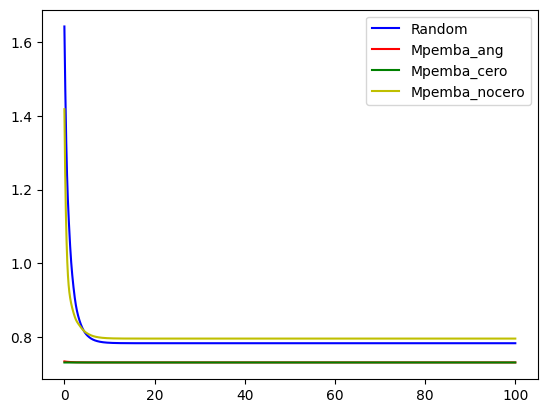

In [ ]:
#Sacamos la distancia de Hilbert Schmidt para todo tiempo t
#ob = [[np.sqrt(np.trace((v[i] - r))) for i in range(len(v))] for v in dens]
ob = [[np.sqrt(np.trace(np.dot(np.conjugate((v[i] - r).T), (v[i] - r)))) for i in range(len(v))] for v in dens]
plt.plot(tiempo, ob[0], 'b-', label = 'Random')
plt.plot(tiempo, ob[1], 'r-', label = 'Mpemba_ang')
plt.plot(tiempo, ob[2], 'g-', label = 'Mpemba_cero')
plt.plot(tiempo, ob[3], 'y-', label = 'Mpemba_nocero')
#plt.xlim(2, 200)
#plt.ylim(0.0, 0.5)
#plt.ylim(0.0, 1.0040)
#plt.xlim(0.0, 15.0)
plt.legend(loc = 'upper right')
#plt.title('Distancia de Hilbert-Schmidt. Modelo de Dicke para N = ' + str(N) + ', k = ' + str(k) + ' y g = ' + str(g))
plt.show()
#ploteo_MC(ob, tiempo)

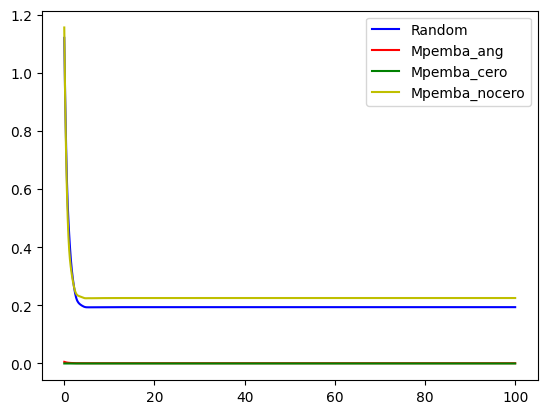

In [ ]:
#Sacamos la distancia de Hilbert Schmidt para todo tiempo t
#ob = [[np.sqrt(np.trace((v[i] - r))) for i in range(len(v))] for v in dens]
ob = [[np.sqrt(np.trace(np.dot(np.conjugate((v[i]).T), (v[i])))) for i in range(len(v))] for v in dens]
plt.plot(tiempo, ob[0], 'b-', label = 'Random')
plt.plot(tiempo, ob[1], 'r-', label = 'Mpemba_ang')
plt.plot(tiempo, ob[2], 'g-', label = 'Mpemba_cero')
plt.plot(tiempo, ob[3], 'y-', label = 'Mpemba_nocero')
#plt.xlim(2, 200)
#plt.ylim(0.0, 0.5)
#plt.ylim(0.0, 1.0040)
#plt.xlim(0.0, 15.0)
plt.legend(loc = 'upper right')
#plt.title('Distancia de Hilbert-Schmidt. Modelo de Dicke para N = ' + str(N) + ', k = ' + str(k) + ' y g = ' + str(g))
plt.show()
#ploteo_MC(ob, tiempo)